# Fine tune Chinese bert with words

CS685 Spring 2022 <br />
Apr. 24, 2022<br />
Hongyu Tu <br />

In [1]:
# 

# from tqdm import tqdm
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModelForMaskedLM

In [3]:
import torch
import pickle
import datasets 
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load data

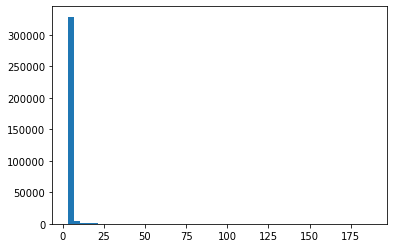

In [36]:
# import matplotlib.pyplot as plt
# a = [len(i) for i in danmu_token]
# plt.hist(a, 50)
# plt.show()

In [6]:
tmp_lst = []

for i in ['danmu', 'comment']:
    with open('{}_token_main.pkl'.format(i), 'rb') as f:
        tmp = pickle.load(f)
        tmp_lst.append(tmp)
    with open('{}_dist_main.pkl'.format(i), 'rb') as f:
        tmp = pickle.load(f)
        tmp_lst.append(tmp)
        
danmu_token, danmu_dist, comment_token, comment_dist = tmp_lst

FileNotFoundError: [Errno 2] No such file or directory: 'danmu_token_main.pkl'

In [5]:
y = [np.argmax(i) for i in danmu_dist]

tmp = {}
for i in y:
    if i in tmp:
        tmp[i] += 1
    else:
        tmp[i] = 1

In [6]:
t_l = list(tmp.keys())
yy = [t_l.index(i) for i in y]
split_idx = int(len(yy) * 0.9)

In [7]:
dataset = datasets.DatasetDict({"train": datasets.Dataset.from_dict({"text": danmu_token[:split_idx], "label": yy[:split_idx]}), \
                                "test": datasets.Dataset.from_dict({"text": danmu_token[split_idx:], "label": yy[split_idx:]})})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 303652
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 33740
    })
})

### Model tuning

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/304 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

In [9]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=len(t_l))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [12]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs = 15)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\tomtu\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1000
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1875


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.379289,0.287000
2,No log,2.799761,0.216000
3,No log,3.022844,0.215000


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


KeyboardInterrupt: 